In [21]:
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

In [23]:
# Load the dataset
data = pd.read_csv('breast-cancer-wisconsin-data.csv')  # Update this with the correct path

In [25]:
# Preprocessing
data = data.drop(columns=['id'])
X = data.drop(columns=['diagnosis']).values  # Features as numpy array
y = data['diagnosis'].apply(lambda x: 1 if x == 'M' else -1).values  # Target as -1 for benign, 1 for malignant

In [27]:
# Split data manually into train and test sets
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.7 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Initialize the AdaBoost implementation from scratch
def decision_stump(X, y, w):
    n, m = X.shape
    best_stump = {}
    min_error = float('inf')

    # Iterate over each feature
    for i in range(m):
        feature_values = np.unique(X[:, i])
        thresholds = (feature_values[:-1] + feature_values[1:]) / 2  # Calculate midpoints between unique values
        for threshold in thresholds:
            for inequality in ['lt', 'gt']:  # Less than or greater than threshold
                prediction = np.ones(n)
                if inequality == 'lt':
                    prediction[X[:, i] <= threshold] = -1
                else:
                    prediction[X[:, i] > threshold] = -1
                error = np.sum(w * (prediction != y))

                if error < min_error:
                    min_error = error
                    best_stump = {
                        'feature_index': i,
                        'threshold': threshold,
                        'inequality': inequality
                    }

    return best_stump, min_error

In [29]:
# AdaBoost from scratch
def ada_boost(X, y, n_estimators, learning_rate):
    n, m = X.shape
    w = np.ones(n) / n  # Initialize equal weights
    weak_classifiers = []
    alpha = []

    for t in range(n_estimators):
        # Train decision stump
        stump, error = decision_stump(X, y, w)

        # Compute the alpha (classifier weight)
        eps = 1e-10  # To avoid division by zero
        classifier_weight = 0.5 * np.log((1 - error) / (error + eps))

        # Store the weak classifier
        weak_classifiers.append(stump)
        alpha.append(classifier_weight)

        # Get predictions from the stump
        prediction = np.ones(n)
        feature = X[:, stump['feature_index']]
        if stump['inequality'] == 'lt':
            prediction[feature <= stump['threshold']] = -1
        else:
            prediction[feature > stump['threshold']] = -1

        # Update weights
        w = w * np.exp(-classifier_weight * y * prediction)
        w = w / w.sum()  # Normalize weights

    return weak_classifiers, alpha

In [31]:
# Prediction function
def predict(X, weak_classifiers, alpha):
    n = X.shape[0]
    final_predictions = np.zeros(n)

    for i, stump in enumerate(weak_classifiers):
        prediction = np.ones(n)
        feature = X[:, stump['feature_index']]
        if stump['inequality'] == 'lt':
            prediction[feature <= stump['threshold']] = -1
        else:
            prediction[feature > stump['threshold']] = -1

        final_predictions += alpha[i] * prediction

    return np.sign(final_predictions)

In [33]:
# Hyperparameter evaluation
def evaluate_hyperparameters(X_train, y_train, X_test, y_test, hyperparams):
    best_accuracy = 0
    best_params = None

    for params in hyperparams:
        n_estimators = params['n_estimators']
        learning_rate = params['learning_rate']

        weak_classifiers, alpha = ada_boost(X_train, y_train, n_estimators, learning_rate)
        y_pred = predict(X_test, weak_classifiers, alpha)
        accuracy = np.mean(y_pred == y_test)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    return best_params, best_accuracy

In [35]:
# Define hyperparameters
hyperparams = [
    {'n_estimators': 50, 'learning_rate': 1.0},
    {'n_estimators': 100, 'learning_rate': 0.5},
    {'n_estimators': 200, 'learning_rate': 0.1},
    {'n_estimators': 50, 'learning_rate': 0.1},
]

In [40]:
# Evaluate the hyperparameters
best_params, best_accuracy = evaluate_hyperparameters(X_train, y_train, X_test, y_test, hyperparams)

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.5}
Best Accuracy: 97.66%


In [41]:
# Final model with best hyperparameters
best_weak_classifiers, best_alpha = ada_boost(X_train, y_train, best_params['n_estimators'], best_params['learning_rate'])
y_pred_final = predict(X_test, best_weak_classifiers, best_alpha)
final_accuracy = np.mean(y_pred_final == y_test)

print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")

Final Model Accuracy: 97.66%


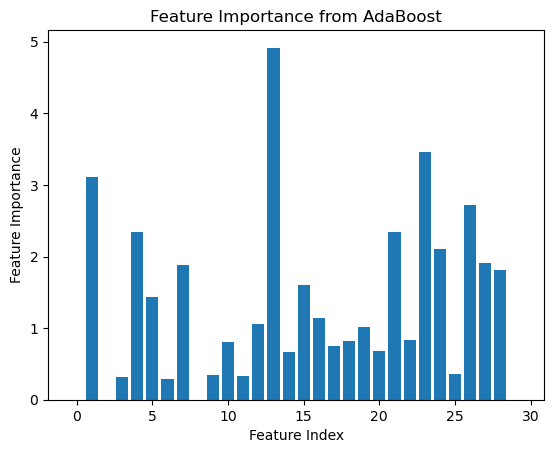

In [42]:
# Plotting feature importance
feature_importance = np.zeros(X_train.shape[1])
for i, stump in enumerate(best_weak_classifiers):
    feature_importance[stump['feature_index']] += best_alpha[i]

plt.bar(range(X_train.shape[1]), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance from AdaBoost')
plt.show()